# Backtest of Model-Based Strategies | Price Lags
---

__Authors:__ Emily Bertani, Max Acheson, Josh Mischung  
__Data Source:__ Yahoo Finance accessed by `pandas-datareader` and `yfinance`  
__Strategy:__ Vectorized Price Lags  
__Instrument(s):__ SPY  

__Intended Use:__  
The primary objective of this notebook is to determine the optimal ML model(s) a strategy based on lagging percent changes. The model(s) chosen at the end of the notebook can be set as a constant, along with the strategy, allowing for further exploration of feature engineering and hyperparameter tuning.

<br>

## Imports & Functions
---
__Imports__

In [1]:
# Data Objects
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta as td

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Data Collection
import pandas_datareader.data as pdr
import yfinance as yf

# Preprocessing and Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis as LDA,
    QuadraticDiscriminantAnalysis as QDA
)
from sklearn.svm import LinearSVC, SVC

# Evaluation
from sklearn.metrics import classification_report

# Settings
yf.pdr_override()


<br>

__Functions__

In [2]:
def create_lagged_series(symbol, start_date, end_date, lags=5):
    """This creates a Pandas DataFrame that stores the
    percentage returns of the adjusted closing value of
    a stock obtained from yahoo finance via panadas-datareader,
    along with a number of lagged returns from the prior
    trading days (lags default to 5 days). Trading volume,
    as well as the Direction from the previous day, are
    also included.
    
    Parameters
    ----------
    symbol : 'str'
        The ticker symbol to obtain from AlphaVantage
    start_date : 'datetime'
        The starting date of the series to obtain
    end_date : 'datetime'
        The ending date of the series to obtain
    lags : 'int', optional
        The number of days to 'lag' the series by
        
    Returns
    -------
    'pd.DataFrame'
        Contains the Adjusted Closing Price returns and lags
    """
    # Obtain stock pricing from Pandas-Datareader
    adj_start_date = start_date - td(days=365)
    ts = pdr.get_data_yahoo(
        symbol,
        start=adj_start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d')
    )
    ts.index = ts.index.date
    
    # Create the new lagged DataFrame
    tslag = pd.DataFrame(index=ts.index)
    tslag['today'] = ts['Adj Close']
    tslag['volume'] = ts['Volume']
    
    # Create shifted lag series of prior trading period close values
    for i in range(0, lags):
        tslag[f"lag_{i+1}"] = ts['Adj Close'].shift(i+1)
        
    # Create returns DataFrame
    tsret = pd.DataFrame(index=tslag.index)
    tsret['volume'] = tslag['volume']
    tsret['today'] = tslag['today'].pct_change()

    # If any of the values of percentage returns eqal zero, set them to
    # a small number (stops issues with QDA model in scikit-learn)
    tsret.loc[tsret['today'].abs() < 0.0001, ['today']] = 0.0001
    
    # Create lagged percentage returns columns
    for i in range(0, lags):
        tsret[f"lag_{i+1}"] = tslag[f"lag_{i+1}"].pct_change()
        
    # Create "Direction" column (+1 or -1) indicating an up/down day
    tsret['direction'] = np.sign(tsret['today'])
    tsret = tsret[tsret.index >= start_date.date()]
    
    return tsret


<br>

## Retreive Data and Generate Features
---

In [3]:
# Set start and end dates of time series
start_date = dt(2016, 1, 10)
end_date = dt(2017, 12, 31)

# Create a DataFrame with daily returns, target, and
# the features that will be used to train the models.
returns_df = create_lagged_series('SPY', start_date, end_date)
returns_df.head()

[*********************100%***********************]  1 of 1 completed


,volume,today,lag_1,lag_2,lag_3,lag_4,lag_5,direction
2016-01-11,187941300,0.000990,-0.010977,-0.023992,-0.012614,0.001691,-0.013979,1.0
2016-01-12,172330500,0.008068,0.000990,-0.010977,-0.023992,-0.012614,0.001691,1.0
2016-01-13,221168900,-0.024940,0.008068,0.000990,-0.010977,-0.023992,-0.012614,-1.0
2016-01-14,240795600,0.016417,-0.024940,0.008068,0.000990,-0.010977,-0.023992,1.0
2016-01-15,324846400,-0.021466,0.016417,-0.024940,0.008068,0.000990,-0.010977,-1.0


<br>

## Train and Evaluate Models
---

In [4]:
# Split returns_df into features and target.
X = returns_df.iloc[:, 2:4].copy()
y = returns_df['direction'].copy()

# Split data into training and testing sets.
start_test = dt(2017, 1, 1)
X_train = X[X.index < start_test.date()]
X_test = X[X.index >= start_test.date()]
y_train = y[y.index < start_test.date()]
y_test = y[y.index >= start_test.date()]

In [5]:
# Create the results DataFrame where each
# model's returns will be stored.
results_df = pd.DataFrame(index=X_test.index)
results_df['Actual'] = returns_df['today']

In [6]:
# Instantiate the models that will be tested.
models = [
    ('LR', LogisticRegression(solver='liblinear')),
    ('LDA', LDA(solver='svd')),
    ('QDA', QDA()),
    ('LSVC', LinearSVC(max_iter=10000)),
    ('RSVC', SVC(
            C=1000000.0, cache_size=200, class_weight=None,
            coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
            max_iter=-1, probability=False, random_state=None,
            shrinking=True, tol=0.001, verbose=False
        )
    ),
    ('RF', RandomForestClassifier(
            n_estimators=1000, criterion='gini',
        max_depth=None, min_samples_split=2,
        min_samples_leaf=1, max_features='auto',
        bootstrap=True, oob_score=False, n_jobs=-1,
        random_state=None, verbose=0
        )
    )
]

# Train and test the models.
print('Hit Rates & Evaluation Report:\n')
for m in models:
    # Build pipeline
    clf = Pipeline(steps=[
        ('scaler', RobustScaler()),
        ('classifier', m[1])
    ])
    
    # Train model
    clf.fit(X_train, y_train)
    
    # Create predictions
    pred = clf.predict(X_test)
    
    # Add the model returns to the returns DataFrame.
    results_df[m[0]] = results_df['Actual'] * pred
    
    # Output hit-rate and confusion matrix
    print(f"{m[0]}:\n{clf.score(X_test, y_test):.3f}")
    print(f"{classification_report(y_test, pred)}\n")

Hit Rates & Evaluation Report:

LR:
0.598
              precision    recall  f1-score   support

        -1.0       0.61      0.10      0.18       105
         1.0       0.60      0.95      0.73       146

    accuracy                           0.60       251
   macro avg       0.60      0.53      0.46       251
weighted avg       0.60      0.60      0.50       251


LDA:
0.602
              precision    recall  f1-score   support

        -1.0       0.65      0.10      0.18       105
         1.0       0.60      0.96      0.74       146

    accuracy                           0.60       251
   macro avg       0.62      0.53      0.46       251
weighted avg       0.62      0.60      0.50       251


QDA:
0.629
              precision    recall  f1-score   support

        -1.0       0.68      0.22      0.33       105
         1.0       0.62      0.92      0.74       146

    accuracy                           0.63       251
   macro avg       0.65      0.57      0.54       251
weighted

<br>

## Evaluate Financial Metrics
---

__Print total returns, annual returns, and Sharpe ratios__

In [7]:
for col_name, col_data in results_df.iteritems():
    tot = (1 + col_data).cumprod()[-1] - 1
    ann = col_data.mean() * 252
    sharpe = ann / (col_data.std() * np.sqrt(252))
    print(
        f"{col_name} yields:" +
        f"\n\t{tot * 100:.2f}% total returns" +
        f"\n\t{ann * 100:.2f}% annual returns" +
        f"\n\t{sharpe:.2f} Sharpe Ratio"
    )

Actual yields:
	21.78% total returns
	20.02% annual returns
	2.97 Sharpe Ratio
LR yields:
	23.47% total returns
	21.40% annual returns
	3.18 Sharpe Ratio
LDA yields:
	24.30% total returns
	22.07% annual returns
	3.29 Sharpe Ratio
QDA yields:
	26.57% total returns
	23.89% annual returns
	3.57 Sharpe Ratio
LSVC yields:
	24.30% total returns
	22.07% annual returns
	3.29 Sharpe Ratio
RSVC yields:
	23.96% total returns
	21.80% annual returns
	3.24 Sharpe Ratio
RF yields:
	13.55% total returns
	13.00% annual returns
	1.91 Sharpe Ratio


__Plot cumulative returns, annual returns, and Sharpe ratios__

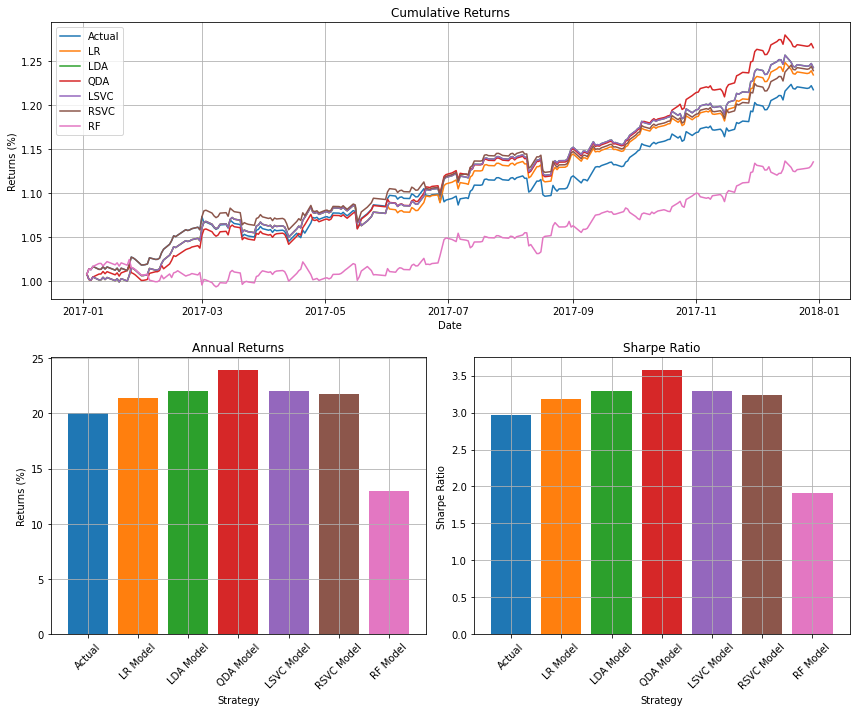

In [8]:
# Create figure layout.
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 4)
ax0 = fig.add_subplot(gs[:2, :4])
ax1 = fig.add_subplot(gs[2:, :2])
ax2 = fig.add_subplot(gs[2:, 2:])

# Create a dictionary to capture performance.
perf_dict = {
    'tot_ret': {},
    'ann_ret': {},
    'sharpe': {}
}

# Populate performance dictionary and
# plot cumulative returns.
for col_name, col_data in results_df.iteritems():
    
    # Populate the performance dictionary
    # for each column.
    perf_dict['tot_ret'][col_name] = (1 + col_data).cumprod()[-1] - 1
    perf_dict['ann_ret'][col_name] = col_data.mean() * 252
    perf_dict['sharpe'][col_name] = perf_dict['ann_ret'][col_name] /\
        (col_data.std() * np.sqrt(252))
    
    # Plot cumulative returns for each column.
    ax0.plot((1 + col_data).cumprod(), label=col_name)
    
# ax0 chart labeling
ax0.set_ylabel('Returns (%)')
ax0.set_xlabel('Date')
ax0.set_title('Cumulative Returns')
ax0.grid()
ax0.legend()

# Plot annual returns
_ = [ax1.bar(i, v * 100) for i, v in enumerate(perf_dict['ann_ret'].values())]
ax1.set_xticks([i for i, k in enumerate(perf_dict['ann_ret'])])
ax1.set_xticklabels(
    [
        f'{k} Model' if k != 'Actual' else 'Actual'
        for k in perf_dict['ann_ret'].keys()
    ],
    rotation=45
)
ax1.grid()
ax1.set_ylabel('Returns (%)')
ax1.set_xlabel('Strategy')
ax1.set_title('Annual Returns')

# Plot Sharpe ratios
_ = [ax2.bar(i, v) for i, v in enumerate(perf_dict['sharpe'].values())]
ax2.set_xticks([i for i, k in enumerate(perf_dict['sharpe'])])
ax2.set_xticklabels(
    [
        f'{k} Model' if k != 'Actual' else 'Actual'
        for k in perf_dict['ann_ret'].keys()
    ],
    rotation=45
)
ax2.grid()
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Strategy')
ax2.set_title('Sharpe Ratio')

# Plot results
plt.tight_layout()
plt.savefig('financialMetrics_mbs_lags.png')
plt.show();